In [9]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

start_time = datetime.strptime('2023/07/15 00:00', '%Y/%m/%d %H:%M')

df = pd.read_csv('../data/worker.csv')
num_total_worker = len(df)
stat = []

# Count missing time entries before dropna
missing_created = df['gmt_created'].isna()
missing_finished = df['gmt_pod_finished'].isna()
missing_time = missing_created | missing_finished
stat.append((sum(missing_time), "MissingTime"))

# Remove entries with any missing 'gmt_created' or 'gmt_pod_finished'
df.dropna(subset=['gmt_created', 'gmt_pod_finished'], how='any', inplace=True)

df['gmt_created'] = df['gmt_created'].apply(
    lambda x: (datetime.strptime(x, '%Y/%m/%d %H:%M') - start_time).total_seconds() / 86400
)
df['gmt_pod_finished'] = df['gmt_pod_finished'].apply(
    lambda x: (datetime.strptime(x, '%Y/%m/%d %H:%M') - start_time).total_seconds() / 86400
)
df['duration'] = df['gmt_pod_finished'] - df['gmt_created']

# Check for invalid duration
invalid_duration_index = df['duration'] <= 0
stat.append((sum(invalid_duration_index), "InvalidDuration"))
df = df[df['duration'] > 0]

# Drop jobs whose host_ip is not in the topo.csv
host_ip_set = set(pd.read_csv('../data/topo.csv')['ip'])
invalid_ip_index = ~df['host_ip'].isin(host_ip_set)
stat.append((sum(invalid_ip_index), "InvalidIP"))
df = df[df['host_ip'].isin(host_ip_set)]

# Check for missing RES
missing_res_index = df['RES'].isna()
stat.append((sum(missing_res_index), "MissingRes"))
df = df.dropna(subset=['RES'])

df

# df['RES'] = df['RES'].apply(ast.literal_eval)
# df['num_gpus'] = df['RES'].apply(lambda x: int(x['nvidia.com/gpu']) if 'nvidia.com/gpu' in x else None)


,id,job_name,worker_name,replica_type,host_ip,gmt_created,gmt_pod_running,gmt_pod_finished,RES,duration
0,28613,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-master-0,master,8bd29cd3a6c570901c5ce23aa0a5557266068fc370e1e4...,0.032639,NaN,0.034028,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.001389
1,28614,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-0,worker,46547b40034dea27dff7a94dee665d3804b7869286d00d...,0.032639,NaN,0.034028,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.001389
2,28615,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-1,worker,47b54b963095fc8211922de281e8a1306783c9809d8ca6...,0.032639,NaN,0.034028,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.001389
3,28616,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-2,worker,7acd990b9db2ffb8b982727c3463746e7c25e0f215c28f...,0.032639,NaN,0.034028,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.001389
4,28617,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-3,worker,2d1f3f74639b00279140135610e4d4cce920754951735f...,0.032639,NaN,0.034028,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.001389
...,...,...,...,...,...,...,...,...,...,...
23737,52350,dlc1g3ccn8neahh9,dlc1g3ccn8neahh9-worker-0,worker,dff008ec40ff0277063879a26fe20839dea357546f8431...,15.952083,2023/7/30 22:53,16.813889,"{""cpu"": ""48"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.861806
23738,52351,dlc1g3ccn8neahh9,dlc1g3ccn8neahh9-worker-1,worker,931e2b5303ad17ad1632a92d75d503163d05102bcd2837...,15.952083,2023/7/30 22:53,16.813889,"{""cpu"": ""48"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.861806
23739,52352,dlc1g3ccn8neahh9,dlc1g3ccn8neahh9-worker-2,worker,93de899743acb06a5fc647679f38ca308b4c37fd290322...,15.952083,2023/7/30 22:53,16.813889,"{""cpu"": ""48"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.861806
23740,52353,dlc1g3ccn8neahh9,dlc1g3ccn8neahh9-worker-3,worker,0bcb143b0d5ecfc59ff7d91e6d254d65ed066352b5317e...,15.952083,2023/7/30 22:53,16.813889,"{""cpu"": ""48"", ""memory"": ""1600Gi"", ""nvidia.com/...",0.861806


In [5]:
stat

[(28, 'MissingTime'),
 (946, 'InvalidDuration'),
 (2917, 'InvalidIP'),
 (5, 'MissingRes')]

In [8]:
assert sum([a for a, _ in stat]) + len(df) == num_total_worker

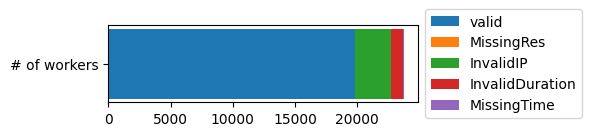

In [17]:
fig, ax = plt.subplots(figsize=(4, 1))
num_workers = len(df)
ax.barh([0], num_workers, label='valid')
for num, reason in stat[::-1]:
    ax.barh([0], num, left=num_workers, label=reason)
    num_workers += num
    
ax.set_yticks([0], labels=["# of workers"])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_ '# of workers'